# 8 Feed forward neural network

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import make_data

## Forward model

<bound method Figure.show of <Figure size 640x480 with 1 Axes>>

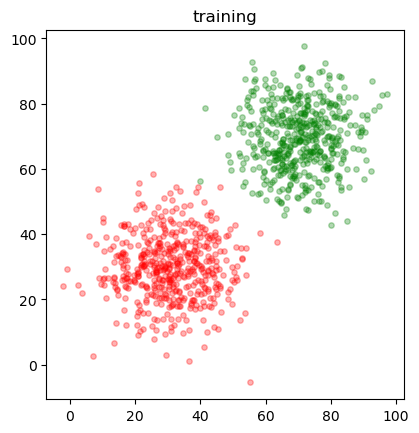

In [36]:
n = 500
example_nr = 1
noise = 1

X, T, x, dim = make_data.make_data(example_nr, n, noise)
fig, ax = plt.subplots(1,1)
ax.scatter(X[0:n,0],X[0:n,1],c = 'red', alpha = 0.3, s = 15)
ax.scatter(X[n:2*n,0],X[n:2*n,1],c = 'green', alpha = 0.3, s = 15)
ax.set_aspect('equal', 'box')
plt.title('training')
fig.show

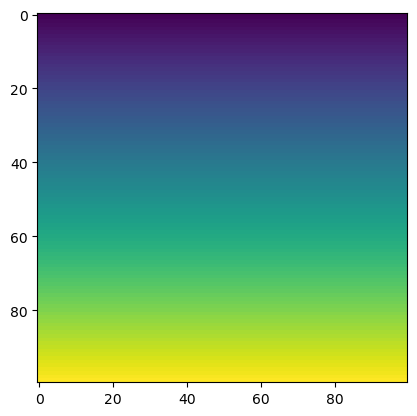

In [37]:
Xo = x.reshape((100,100,2))
plt.imshow(Xo[:,:,1])

In [38]:
m = np.mean(X,axis = 0)
s = np.std(X,axis = 0)

Xc = (X - m)/s
xc = (x - m)/s


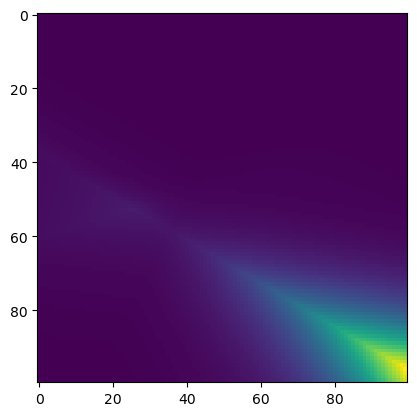

In [39]:
n_hidden = 10
W = []
W.append(np.random.randn(3,n_hidden)*np.sqrt(2/3))
W.append(np.random.randn(n_hidden+1,2)*np.sqrt(2/4))

def forwardsimple(xb, W):
    n_pts = xb.shape[0]
    z = np.c_[xb, np.ones(n_pts)]@W[0]
    h = np.maximum(z, 0)
    yh = np.c_[h, np.ones(n_pts)]@W[1]
    y = np.exp(yh)/np.sum(np.exp(yh),axis=1,keepdims=True)
    return y, h

y, h = forwardsimple(xc, W)
y.shape

Y = y.reshape((100,100,2))
plt.imshow(Y[:,:,1])

In [40]:
y.shape

(10000, 2)

## MLP

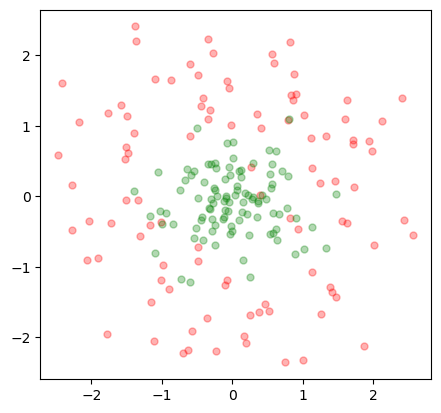

In [34]:
n = 100
example_nr = 2
noise = 1.75

X, T, x, dim = make_data.make_data(example_nr, n, noise)

# Standardize
m = np.mean(X,axis=0)
s = np.std(X,axis=0)
Xc = (X-m)/s
xc = (x-m)/s


fig, ax = plt.subplots(1)
ax.plot(Xc[:n,0],Xc[:n,1],'r.',markersize=10,alpha=0.3)
ax.plot(Xc[n:,0],Xc[n:,1],'g.',markersize=10,alpha=0.3)
ax.set_aspect('equal')

In [11]:
#%% Forward simple model

# Function for simple forward pass
def simple_forward(x, W):
    z = np.c_[x,np.ones((x.shape[0]))]@W[0]
    h = np.maximum(z,0)
    yh = np.c_[h,np.ones((x.shape[0]))]@W[1]
    y = np.exp(yh)/np.sum(np.exp(yh),axis=1,keepdims=True)
    return y, h

# Function for simple backpropagation
def simple_backward(x, W, t, learning_rate=0.1):
    y, h = simple_forward(x,W)
    L = -np.sum(t*np.log(y + 10e-10))/x.shape[0]
    # print(L)
    d1 = y - t
    q1 = np.c_[h,np.ones((x.shape[0]))].T@d1/y.shape[0]
    d0 = (h>0)*(d1@W[1].T)[:,:-1]
    q0 = np.c_[x,np.ones((x.shape[0]))].T@d0/y.shape[0]
    W[0] -= learning_rate*q0
    W[1] -= learning_rate*q1
    return W, L

# Function for simple weight initializaion
def simple_init_weights(n):
    W = []
    W.append(np.random.randn(3,n)*np.sqrt(2/3))
    W.append(np.random.randn(n+1,2)*np.sqrt(2/(n+1)))
    return W

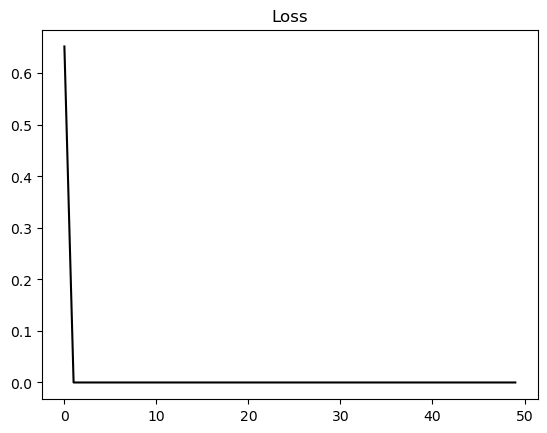

In [12]:
W = simple_init_weights(3)

fig, ax = plt.subplots(1)
n_iter = 50
L = np.zeros((n_iter))
i_rng = np.arange(0,n_iter) 
for i in range(0,n_iter):
    W, L[i] = simple_backward(Xc,W,T,learning_rate = 0.5)
    ax.cla()
    ax.plot(i_rng,L,'k')
    ax.set_title('Loss')
    plt.pause(0.001)
    plt.show()
    

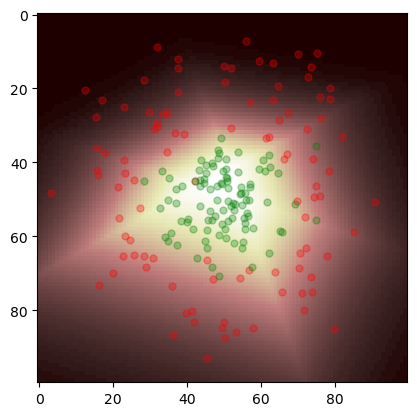

In [13]:
y = simple_forward(xc,W)[0]

# Display the result
Y = y.reshape((100,100,2))
fig,ax = plt.subplots(1)
ax.imshow(Y[:,:,1],cmap='pink')
ax.plot(X[:n,0],X[:n,1],'r.',markersize=10,alpha=0.3)
ax.plot(X[n:,0],X[n:,1],'g.',markersize=10,alpha=0.3)
ax.set_aspect('equal')

In [14]:
#%% Varying number of layers

nl = [x.shape[1], 50,50,50,50, 2]
def init_weights(nl):
    W = []
    for i in range(1,len(nl)):
        W.append(np.random.randn(nl[i-1]+1,nl[i])*np.sqrt(2/(nl[i-1]+1)))
    return W

W = init_weights(nl)

In [15]:
def forward(x, W):
    n = len(W)
    z = []
    h = []
    z.append(np.c_[x,np.ones((x.shape[0]))]@W[0])
    h.append(np.maximum(z[0],0))
    for i in range(1,n-1):
        z.append(np.c_[h[i-1],np.ones((x.shape[0]))]@W[i])
        h.append(np.maximum(z[i],0))
    
    yh = np.maximum(np.minimum(np.c_[h[-1],np.ones((x.shape[0]))]@W[-1],600),-600)
    y = np.exp(yh)/(np.sum(np.exp(yh),axis=1,keepdims=True))
    return y, h

def backward(x, W, t, learning_rate=0.01, show_learning=False):
    y,h = forward(x,W)
    L = -np.sum(t*np.log(y + 10e-7))/x.shape[0]
    if show_learning:
        print(L)
    n = len(W)
    d = []
    q = []
    d.append(y - t)
    for i in range(1,n):
        q.append((np.c_[h[n-i-1],np.ones((x.shape[0]))].T@d[i-1])/y.shape[0])
        d.append((h[n-i-1]>0)*(d[i-1]@W[n-i].T)[:,:-1])
    q.append((np.c_[x,np.ones((x.shape[0]))].T@d[-1])/y.shape[0])

    for i in range(0,n):
        W[i] -= learning_rate*q[n-i-1]
    return W, L

0.7872310701987304


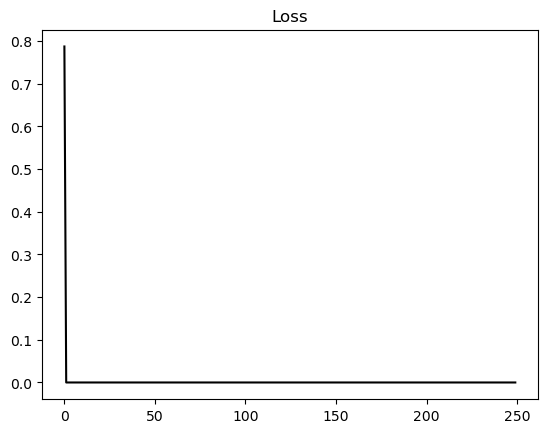

0.7503733933263496
0.7814904654130761
0.44498481879649804
0.40343805166455204
0.37462562566395646
0.35268892124034407
0.334036819615851
0.3171805502911175
0.3017329488943735
0.2874800081077521
0.2742402191009199
0.26170354658422296
0.2503439227160725
0.23969852420569232
0.22978418819124413
0.2209271013036772
0.2129133748936322
0.20549987354858376
0.1988945692546877
0.19296283605504133
0.18771457773878034
0.182921298478942
0.1783949838734378
0.17429145831810935
0.17056931488272883
0.16719645740855157
0.16417655097038725
0.1614282822768442
0.15895290696208278
0.15665318193315717
0.15446240183860868
0.15243979266651556
0.15046653902636753
0.1485995210120633
0.14683987178930363
0.14526784853249666
0.14382640434918412
0.14242959368017236
0.14112561880886035
0.13981261149479537
0.1386885735130776
0.13749559432466227
0.13639237973818857
0.13534934145615235
0.13428732100217883
0.13338427228262817
0.13255635016147
0.13182894743703907
0.13171820791168515
0.13218613386731748
0.13427326651111637
0

In [16]:
fig, ax = plt.subplots(1)
n_iter = 250
L = np.zeros((n_iter))
i_rng = np.arange(0,n_iter) 
for i in range(0,n_iter):
    W, L[i] = backward(Xc,W,T,learning_rate=0.1,show_learning=True)
    if ( i%10 == 0):
        ax.cla()
        ax.plot(i_rng,L,'k')
        ax.set_title('Loss')
        plt.pause(0.001)
        plt.show()

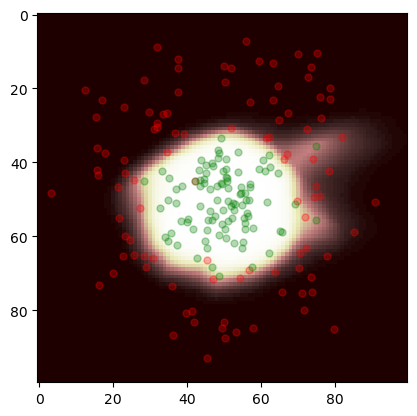

In [17]:
y = forward(xc,W)[0]

Y = y.reshape((100,100,2))
fig,ax = plt.subplots(1)
ax.imshow(Y[:,:,1],cmap='pink')
ax.plot(X[:n,0],X[:n,1],'r.',markersize=10,alpha=0.3)
ax.plot(X[n:,0],X[n:,1],'g.',markersize=10,alpha=0.3)
ax.set_aspect('equal')

0.9483128917270681
0.8313967869736978
0.5594676621212389
0.5446917894173445
0.5062513600563927
0.526843003056003
0.6140291271823981
0.8513681655012608
0.4655354724595709
0.31242533244170684
0.40025961990790837
0.48555144354660207
0.5541953910700703
0.4358725681888612
0.6760892450233849
0.37827971636540686
0.5076837360838445
0.6209379727769486
0.34167436461315237
0.5465814463784573


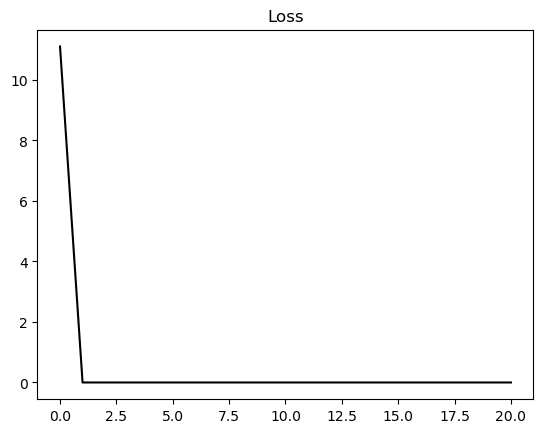

0.43822549034921315
0.41114861026403204
0.41099460117331815
0.37475617118833193
0.44525497884271237
0.2407798793332853
0.6810492967688118
0.44032129312332946
0.2689516499016822
0.3710175819083386
0.3726820196758316
0.4283111193493956
0.3323860497866323
0.37025073670854736
0.4674945360463437
0.5575655570451171
0.4020636476569469
0.23677447576784685
0.37831644947955
0.255620571158186
0.7041596740622666
0.20688272368397476
0.4535826324374109
0.1874516484494839
0.4360387615024968
0.16103427633732215
0.2745025467380935
0.2831287263535046
0.5313586934207539
0.2040447899330172
0.4449064779989159
0.3817729294094857
0.2596355230293626
0.1703326328448518
0.4076306663731063
0.2642291042234478
0.25618692228475987
0.28772174832609954
0.20975686840279453
0.4058963143084899
0.15559110191871978
0.15289272110248703
0.36264038842664703
0.1751271608715928
0.5760150202556813
0.5142149690150486
0.3484136829894375
0.22907906755553906
0.15603830851672962
0.2442707464879416
0.17939211241395
0.1599349133705929

In [18]:
#%% Now with mini batches
nl = [x.shape[1], 50,50,50,50, 2]

batch_size = 10

W = init_weights(nl)
fig, ax = plt.subplots(1)
n_iter = 21
L = np.zeros((n_iter))
i_rng = np.arange(0,n_iter) 
for i in range(0,n_iter):
    nb = Xc.shape[0]
    idx = np.random.permutation(nb)
    for j in range(0,nb,batch_size):
        Xb = Xc[idx[j:j+batch_size],:]
        Tb = T[idx[j:j+batch_size],:]
        W, l = backward(Xb,W,Tb,learning_rate=0.01,show_learning=True)
        L[i] += l
    if ( i%10 == 0):
        ax.cla()
        ax.plot(i_rng,L,'k')
        ax.set_title('Loss')
        plt.pause(0.001)
        plt.show()


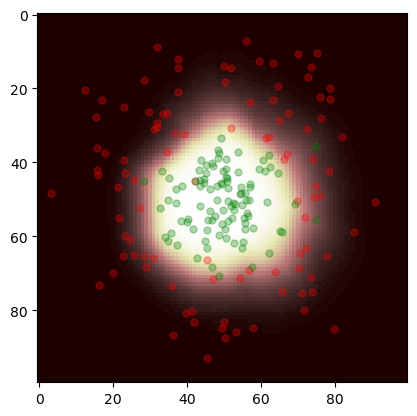

In [19]:
y = forward(xc,W)[0]

Y = y.reshape((100,100,2))
fig,ax = plt.subplots(1)
ax.imshow(Y[:,:,1],cmap='pink')
ax.plot(X[:n,0],X[:n,1],'r.',markersize=10,alpha=0.3)
ax.plot(X[n:,0],X[n:,1],'g.',markersize=10,alpha=0.3)
ax.set_aspect('equal')